# Import data and libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import sklearn.preprocessing as preproc
from sklearn.metrics import classification_report, confusion_matrix, matthews_corrcoef, accuracy_score

from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, InputLayer
from tensorflow.keras.callbacks import EarlyStopping

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

import scripts

# constants and settings
rand_seed = 35

2025-11-05 22:58:45.070898: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Load the data
tree_data = pd.read_csv('../data/covtype.data', header=None)
tree_cols = ['Elevation', 'Aspect', 'Slope', 'Horizontal_To_Hydrology',
             'Vertical_To_Hydrology', 'Horizontal_To_Roadways',
             'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
             'Horizontal_To_Fire'] + \
            [f'Wilderness_Area_{i}' for i in range(4)] + \
            [f'Soil_Type_{i}' for i in range(40)] + \
            ['Cover_Type']

# print(tree_data.describe())

In [3]:
tree_data.columns = tree_cols
print("Nan values in dataset:", tree_data.isna().sum().sum())
print(f"Dataset shape: {tree_data.shape}")

Nan values in dataset: 0
Dataset shape: (581012, 55)


# Data exploration

In [4]:
tree_reduced = scripts.sample_stratify(tree_data, 'Cover_Type', n_samples=60000, rand_state=rand_seed)
X_tree, y_tree = tree_reduced.drop(columns=['Cover_Type']), tree_reduced['Cover_Type']
y_tree -= 1  # make labels zero-indexed

print(y_tree.value_counts())

Cover_Type
1    29256
0    21876
2     3692
6     2118
5     1794
4      980
3      284
Name: count, dtype: int64


Very uneven label distribution, mostly centered on types 1 and 2.
Stratified sampling require to ensure labels 3-7 are properly represented in training.

In [5]:
# target_over = {3: 1000, 4: 1000, 5: 1000, 6: 1000}
target_over = {3: 600}
# target_under = {0: 1000, 1: 1000, 2: 1000}
target_under = {0: 8000, 1: 8000}

In [6]:
# std_scaler, x_st_scale = scripts.normalize_data(X_tree, method='standard')
scaler = preproc.StandardScaler()
x_st_scale = scaler.fit_transform(X_tree)

## Split training/testing data

In [7]:
x_train, x_test, y_train, y_test = train_test_split(x_st_scale, y_tree, test_size=0.2, stratify=y_tree, random_state=rand_seed)


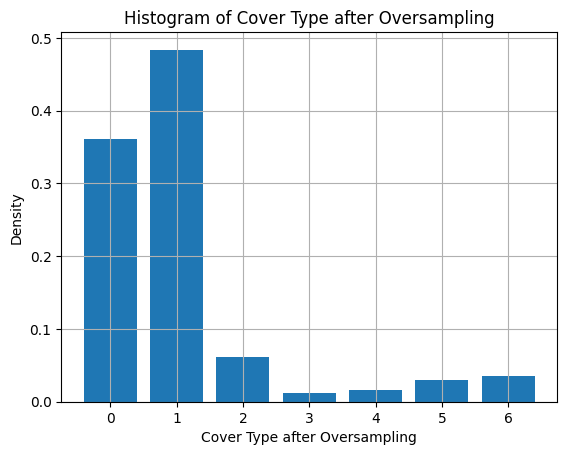

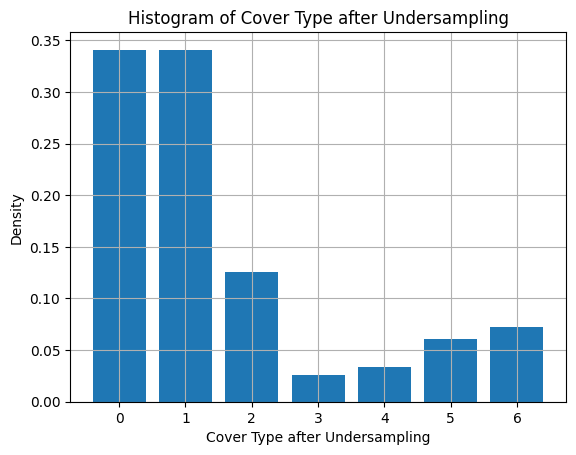

In [8]:
# Oversample minority categories
x_resample, y_resample = SMOTE(random_state=rand_seed, sampling_strategy=target_over, k_neighbors=2).fit_resample(x_train, y_train)
scripts.plot_histogram(y_resample, label='Cover Type after Oversampling')

# Undersample majority categories
x_resample, y_resample = RandomUnderSampler(random_state=rand_seed, sampling_strategy=target_under).fit_resample(x_resample, y_resample)
scripts.plot_histogram(y_resample, label='Cover Type after Undersampling')

x_train, x_val, y_train, y_val = train_test_split(x_resample, y_resample, test_size=0.2, stratify=y_resample, random_state=rand_seed)


# Perceptron model training

In [9]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

drop_fraction = 0.2
model = Sequential([
    InputLayer(input_shape=(54,)),
    Dense(128, activation='relu'),
    # Dropout(drop_fraction),
    Dense(128, activation='relu'),
    # Dropout(drop_fraction),
    Dense(64, activation='relu'),
    # Dropout(drop_fraction),
    Dense(7, activation='softmax')
])

/home/alex/Class/CSCI635/CSCI-635-1-Group-5/venv/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
I0000 00:00:1762401560.325079   31047 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3974 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5


In [13]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4),
                        loss='sparse_categorical_crossentropy',
                        metrics=['accuracy'])

In [14]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         7,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,263 (126.03 KB)

 Trainable params: 32,263 (126.03 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
history = model.fit(x_train, y_train,
                    validation_data=(x_val, y_val),
                    epochs=400,
                    batch_size=1024,
                    callbacks=[es],
                    verbose=1)

Epoch 1/400


2025-11-05 23:00:07.425812: I external/local_xla/xla/service/service.cc:163] XLA service 0x74871800d650 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-11-05 23:00:07.425824: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 2060, Compute Capability 7.5
2025-11-05 23:00:07.443596: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-11-05 23:00:07.569091: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91500


 1/19 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.2686 - loss: 1.9458

I0000 00:00:1762401608.320100   70914 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - accuracy: 0.3269 - loss: 1.8794 - val_accuracy: 0.3788 - val_loss: 1.7929
Epoch 2/400
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3965 - loss: 1.7400 - val_accuracy: 0.4274 - val_loss: 1.6727
Epoch 3/400
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4462 - loss: 1.6289 - val_accuracy: 0.4712 - val_loss: 1.5688
Epoch 4/400
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4945 - loss: 1.5274 - val_accuracy: 0.5119 - val_loss: 1.4710
Epoch 5/400
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5237 - loss: 1.4300 - val_accuracy: 0.5360 - val_loss: 1.3761
Epoch 6/400
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5454 - loss: 1.3362 - val_accuracy: 0.5528 - val_loss: 1.2856
Epoch 7/400
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5585 - loss: 1.2466 - val_accuracy: 0.5654 - val_loss: 1.1999
Epoch 8/400
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5761 - loss: 1.1626 - val_accuracy: 0.5780 - val_loss: 1.

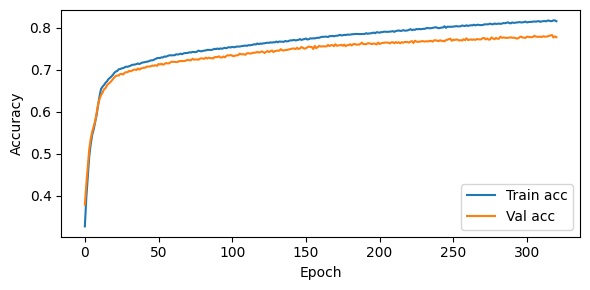

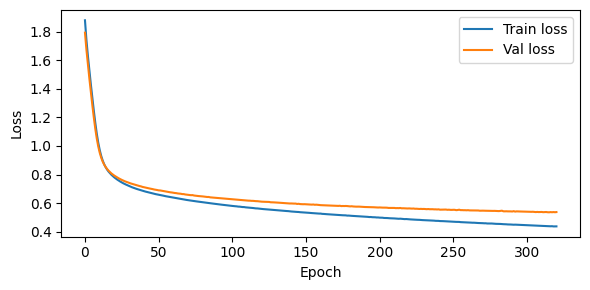

In [16]:
import matplotlib.pyplot as plt
# Visualizations
plt.figure(figsize=(6,3))
plt.plot(history.history["accuracy"], label="Train acc")
plt.plot(history.history["val_accuracy"], label="Val acc")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend(); plt.tight_layout()
plt.show()

plt.figure(figsize=(6,3))
plt.plot(history.history["loss"], label="Train loss")
plt.plot(history.history["val_loss"], label="Val loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.tight_layout()
plt.show()

In [17]:
test_pred = model.predict(x_test)
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 647us/step
Test Loss: 0.5274, Test Accuracy: 0.7800
